In [218]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [219]:
script_dir = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
seed = 0

In [220]:
class Hopfield:
    def __init__(self, size):
        self.size = size
        self.weights = np.zeros((size, size))

    def train_hebb(self, patterns, lr=1.0):
        self.weights = np.zeros((self.size, self.size))

        for pattern in patterns:
            self.weights += lr * np.outer(pattern, pattern)

        np.fill_diagonal(self.weights, 0)
        self.weights /= len(patterns)
    
    def train_oja(self, patterns, lr=0.001):
        self.weights = np.random.uniform(-1, 1, (self.size, self.size)) / np.sqrt(self.size)
        np.fill_diagonal(self.weights, 0)

        for _ in range(100):
            for pattern in patterns:
                x = pattern
                w = self.weights
                y = w.T @ x
                # dw = lr * (np.outer(y, x) - np.outer(y, y) @ w)
                dw = lr * np.outer(y, (x - y @ w))
                self.weights += dw / len(patterns)
                np.fill_diagonal(self.weights, 0)

    def energy(self, state):
        return -0.5 * np.dot(np.dot(state, self.weights), state)

    def update(self, state, num_iterations=100, update_type="sync"):
        state = state.copy()

        for _ in range(num_iterations):
            if update_type == "async":
                for i in np.random.permutation(self.size):
                    activation = np.dot(self.weights[i], state)
                    state[i] = 1 if activation >= 0 else -1
            else:
                activation = np.dot(self.weights, state)
                state = np.where(activation >= 0, 1, -1)

        return state

In [221]:
def shuffle_pattern(pattern, prob):
    noise = np.random.rand(pattern.size) < prob
    noisy_pattern = np.where(noise, -1 * pattern, pattern)
    
    return noisy_pattern

In [222]:
def show_pattern(pattern, size):
    pattern = pattern.copy()
    pattern.shape = size
    plt.imshow(pattern, cmap="gray")
    plt.show()

In [223]:
def pattern_diff(pattern1, pattern2):
    return np.sum(pattern1 != pattern2)

In [224]:
folder_path = 'data'
files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

In [225]:
patterns = pd.read_csv(files[0], header=None).values

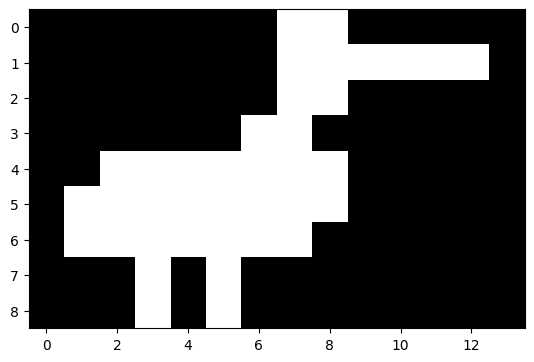

In [226]:
show_pattern(patterns[1], (9, 14))

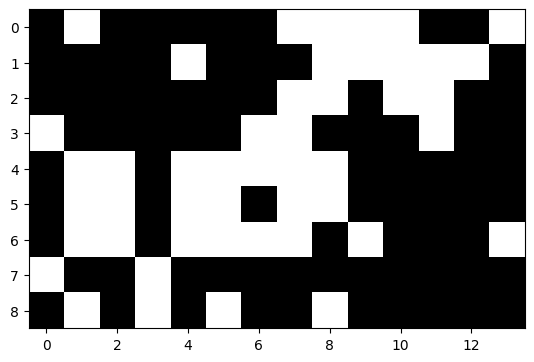

In [227]:
noisy_pattern = shuffle_pattern(patterns[1], 0.1)
show_pattern(noisy_pattern, (9, 14))

In [228]:
hebb_net = Hopfield(len(patterns[0]))
hebb_net.train_hebb(patterns)

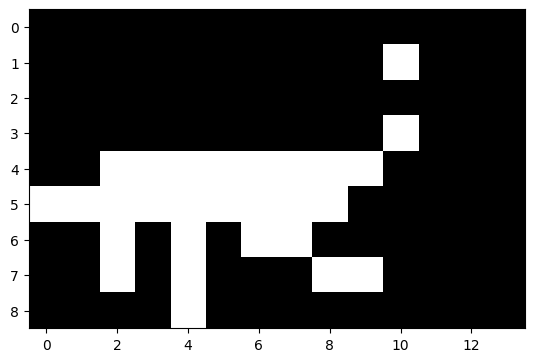

Energy: -2078.6666666666665
Diff: 26


In [229]:
recalled_pattern = hebb_net.update(noisy_pattern, num_iterations=100)
show_pattern(recalled_pattern, (9, 14))
print("Energy:", hebb_net.energy(recalled_pattern))
print("Diff:", pattern_diff(recalled_pattern, patterns[1]))

In [230]:
import re

def extract_dataset_size(input_string):
    match = re.search(r'(\w+)-(\d+x\d+)', input_string)
    if match:
        dataset_size = match.group(2).split('x')
        return int(dataset_size[0]), int(dataset_size[1])
    return None, None

In [231]:
data = []
for file in files:
    name = os.path.basename(file)
    data.append({
        'df': pd.read_csv(file, header=None).values,
        'name': name,
        'size': extract_dataset_size(name)
    })

In [232]:
shuffle_chance = 0.3
for dataset in data:
    print(dataset['name'], dataset['size'])
    size = dataset['size'][0] * dataset['size'][1]
    hebb_net = Hopfield(size)
    hebb_net.train_hebb(dataset['df'])
    oja_net = Hopfield(size)
    oja_net.train_oja(dataset['df'])

    hebb_total_diff = 0
    hebb_correct = 0
    oja_total_diff = 0
    oja_correct = 0
    for pattern in dataset['df']:
        noisy_pattern = shuffle_pattern(pattern, shuffle_chance)
        recalled_pattern = hebb_net.update(noisy_pattern, num_iterations=100)
        diff = pattern_diff(recalled_pattern, pattern)
        if diff == 0:
            hebb_correct += 1
        hebb_total_diff += diff

        recalled_pattern = oja_net.update(noisy_pattern, num_iterations=100)
        diff = pattern_diff(recalled_pattern, pattern)
        if diff == 0:
            oja_correct += 1
        oja_total_diff += diff
    print('Average diff (Hebb):', f'{hebb_total_diff / len(dataset['df']) / size:.3f}')
    print('Correct (Hebb):', f'{hebb_correct / len(dataset['df']):.3f}')
    print('Average diff (Oja):', f'{oja_total_diff / len(dataset['df']) / size:.3f}')
    print('Correct (Oja):', f'{oja_correct / len(dataset['df']):.3f}')

animals-14x9.csv (14, 9)
Average diff (Hebb): 0.194
Correct (Hebb): 0.167
Average diff (Oja): 0.361
Correct (Oja): 0.000
large-25x25.csv (25, 25)
Average diff (Hebb): 0.055
Correct (Hebb): 0.500
Average diff (Oja): 0.411
Correct (Oja): 0.000
large-25x25.plus.csv (25, 25)
Average diff (Hebb): 0.298
Correct (Hebb): 0.000
Average diff (Oja): 0.417
Correct (Oja): 0.000
large-25x50.csv (25, 50)


KeyboardInterrupt: 